<a href="https://colab.research.google.com/github/SnkhchyanV/NeuralNetworks/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


In [1]:
!pip install scikit-learn
!pip install scikit-image


## Prepare the data

In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from cv2 import imread, resize
import tensorflow_probability as tfp

In [3]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from lfw_dataset import fetch_lfw_dataset


In [4]:
def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(lambda img: img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: resize(img, (dimx, dimy)))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs

In [5]:
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [6]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [7]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [8]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [9]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

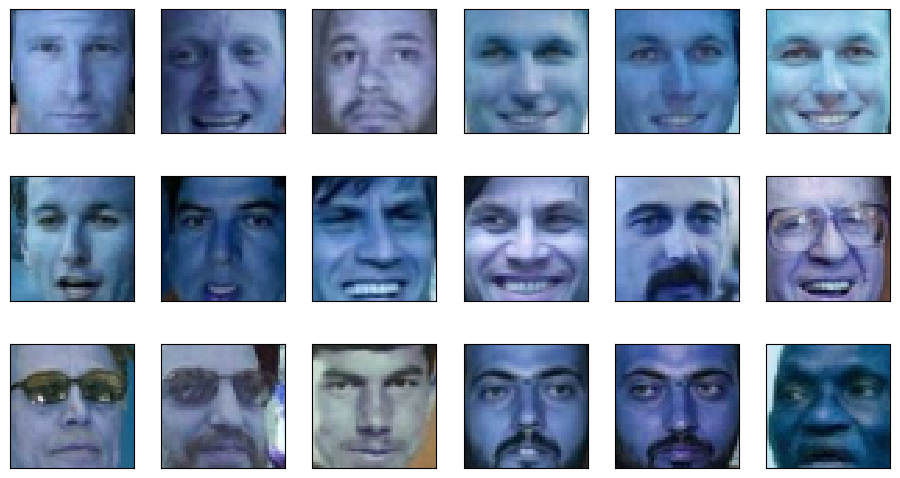

In [10]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:


<img src="/content/Autoencoder_structure.jpg">

In [11]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# You can define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# However, you can just have 1 fc layer in each network without any activation,
# and it will also show some results

vanila_encoder = tf.keras.Sequential()
vanila_encoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_encoder.add(L.Dense(dimZ, kernel_initializer=I.GlorotUniform()))
vanila_decoder = tf.keras.Sequential()
vanila_decoder.add(L.Dense(4*dimZ, activation='relu', kernel_initializer=I.GlorotUniform()))
vanila_decoder.add(L.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=I.GlorotUniform()))

model = tf.keras.Sequential()
model.add(vanila_encoder)
model.add(vanila_decoder)

In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [13]:
# Create MSE loss function
loss = tf.keras.losses.mean_squared_error
# Use Adam optimizer
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt)
callback = DisplayCallback(model, 10)

In [14]:
model.build(input_shape=X_train.shape)

Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 0.0172

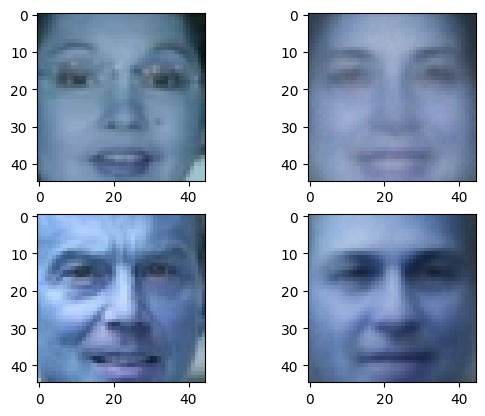

313/313 [==============================] - 10s 8ms/step - loss: 0.0172 - val_loss: 0.0125
Epoch 2/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0104
Epoch 3/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 4/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 6/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 7/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 9/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 10/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 11/

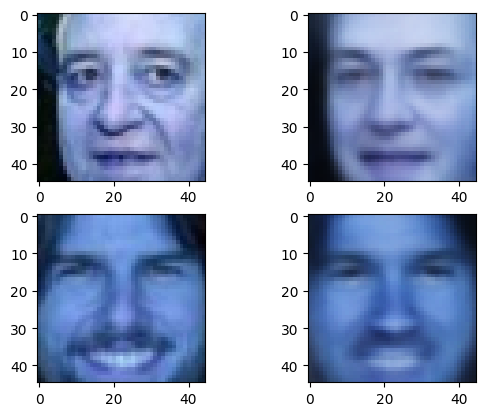

313/313 [==============================] - 2s 6ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 12/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 13/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 14/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 15/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 16/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 17/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 18/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 19/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 20/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0050
Ep

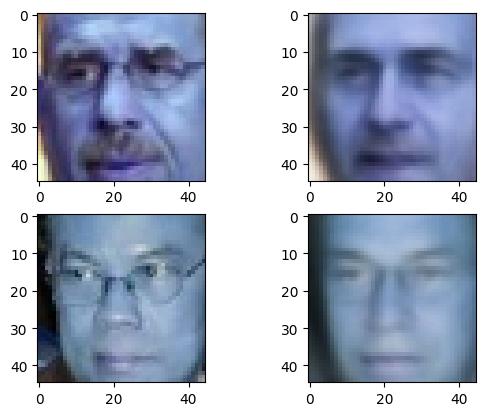

313/313 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 22/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 23/30
313/313 [==============================] - 2s 7ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 24/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 25/30
313/313 [==============================] - 1s 5ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 26/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 27/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 28/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 29/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 30/30
313/313 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0051


In [15]:
# Train your autoencoder
# Add validation data
# Visualize progress in reconstruction and loss decay
history = model.fit(
    X_train, X_train,
    epochs=30,
    validation_data = (X_val, X_val),
    callbacks=[callback]
)

Plot your loss values (also metrics, if you used them) for train and validation data

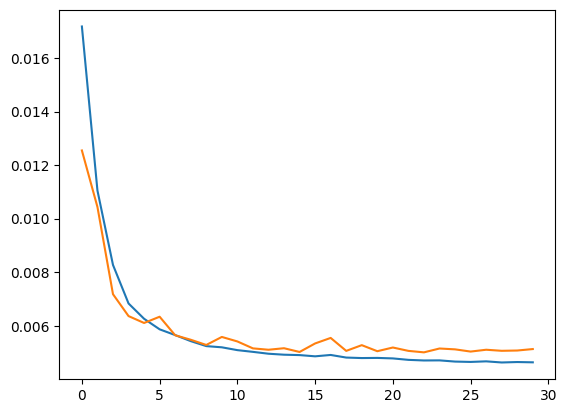

In [16]:
plt.plot(np.arange(30), history.history['loss'])
plt.plot(np.arange(30), history.history['val_loss'])
plt.show()

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

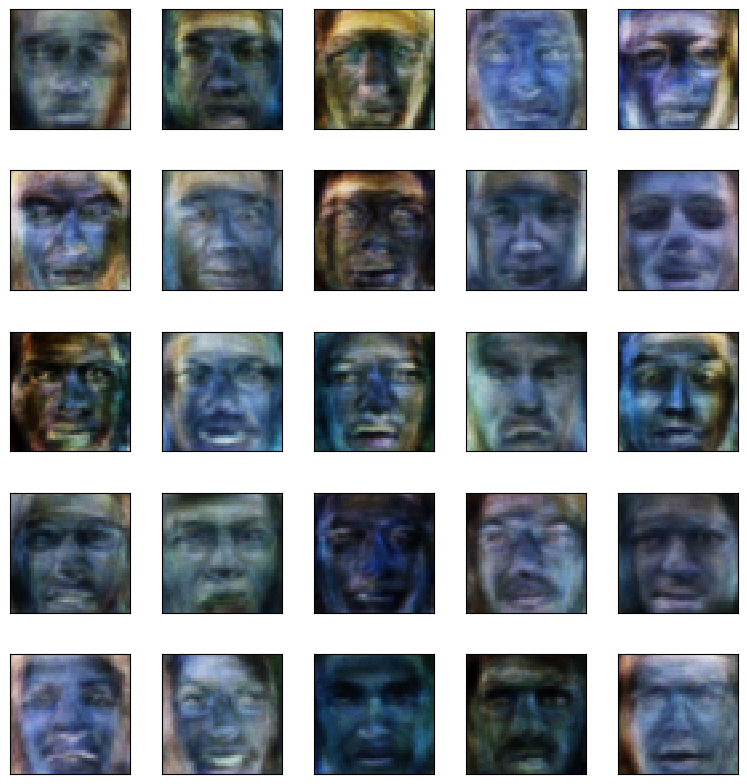

In [17]:
z = np.random.randn(25, dimZ)
output = vanila_decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

# Homework: Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [18]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

input_shape = (6075,)
encoder_input = tf.keras.layers.Input(shape=input_shape)
encoder_hidden = tf.keras.layers.Dense(256, activation='relu')(encoder_input)
encoder_mean = tf.keras.layers.Dense(dimZ)(encoder_hidden)
encoder_log_variance = tf.keras.layers.Dense(dimZ)(encoder_hidden)

decoder_input = tf.keras.layers.Input(shape=(dimZ,))
decoder_hidden = tf.keras.layers.Dense(256, activation='relu')(decoder_input)
decoder_output = tf.keras.layers.Dense(6075, activation='sigmoid')(decoder_hidden)

encoder = tf.keras.Model(encoder_input, [encoder_mean, encoder_log_variance])
decoder = tf.keras.Model(decoder_input, decoder_output)


And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [25]:

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    @tf.function
    def KL_divergence(self, mu, logsigma):
        kl_loss = -0.5 * tf.reduce_sum(1 + logsigma - tf.square(mu) - tf.exp(logsigma), axis=1)
        return tf.reduce_mean(kl_loss)

    # @tf.function
    # def log_likelihood(self, x, z):
    #     epsilon = 0.00001
    #     temp = self.decoder(z)
    #     log_prob = -tf.reduce_sum(x * tf.math.log(temp+ epsilon) + (1 - x) * tf.math.log(1 - temp + epsilon), axis=1)
    #     return tf.reduce_mean(log_prob)

    @tf.function
    def log_likelihood(self, x, z):
        reconstruction = self.decoder(z)
        return tf.reduce_mean(tf.reduce_sum(tf.square(x-reconstruction), axis=-1))

    def train_step(self, x):
        with tf.GradientTape() as tape:
            mu, logsigma = self.encoder(x)
            epsilon = tf.random.normal(tf.shape(mu))
            z = mu + tf.exp(0.5 * logsigma) * epsilon
            kl_loss = self.KL_divergence(mu, logsigma)
            log_likelihood = self.log_likelihood(x, z)
            total_loss = kl_loss - log_likelihood

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": total_loss, "kl_loss": kl_loss, "log_likelihood": log_likelihood}

    def call(self, inputs):
        mu, logsigma = self.encoder(inputs)
        epsilon = tf.random.normal(tf.shape(mu))
        z = mu + tf.exp(0.5 * logsigma) * epsilon
        outputs = self.decoder(z)
        return outputs



In [26]:
vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer=optimizer)


And train the model:

(10000, 6075)
Epoch 1/30
308/313 [============================>.] - ETA: 0s - loss: -2416.5219 - kl_loss: 0.0173 - log_likelihood: 2416.5392

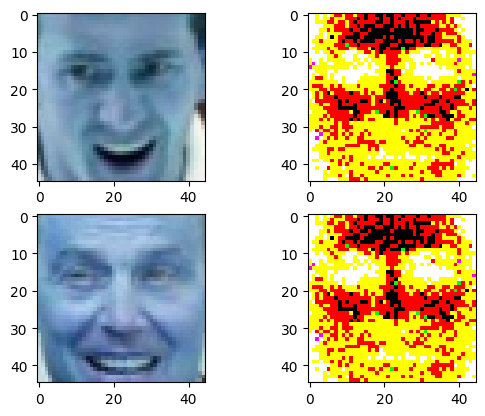

313/313 [==============================] - 4s 5ms/step - loss: -2416.0497 - kl_loss: 0.0170 - log_likelihood: 2416.0667
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: -2415.8613 - kl_loss: 1.3795e-06 - log_likelihood: 2415.8613
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.1184 - kl_loss: 5.9348e-07 - log_likelihood: 2416.1184
Epoch 4/30
313/313 [==============================] - 1s 4ms/step - loss: -2415.7463 - kl_loss: -1.6290e-06 - log_likelihood: 2415.7463
Epoch 5/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.4501 - kl_loss: -2.9038e-06 - log_likelihood: 2416.4501
Epoch 6/30
313/313 [==============================] - 1s 4ms/step - loss: -2415.9047 - kl_loss: -3.5425e-06 - log_likelihood: 2415.9047
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: -2415.9680 - kl_loss: -3.8536e-06 - log_likelihood: 2415.9680
Epoch 8/30
313/313 [==============================] - 2s 5ms/step 

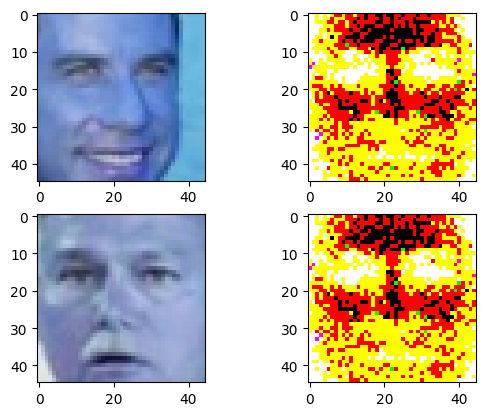

313/313 [==============================] - 2s 5ms/step - loss: -2415.9202 - kl_loss: -3.6738e-06 - log_likelihood: 2415.9202
Epoch 12/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.4540 - kl_loss: -3.5747e-06 - log_likelihood: 2416.4540
Epoch 13/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.4061 - kl_loss: -3.3787e-06 - log_likelihood: 2416.4061
Epoch 14/30
313/313 [==============================] - 1s 4ms/step - loss: -2415.9626 - kl_loss: -3.0795e-06 - log_likelihood: 2415.9626
Epoch 15/30
313/313 [==============================] - 1s 4ms/step - loss: -2415.9968 - kl_loss: -2.5162e-06 - log_likelihood: 2415.9968
Epoch 16/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.1254 - kl_loss: -1.9511e-06 - log_likelihood: 2416.1254
Epoch 17/30
313/313 [==============================] - 2s 6ms/step - loss: -2415.9702 - kl_loss: -1.3742e-06 - log_likelihood: 2415.9702
Epoch 18/30
313/313 [==============================] 

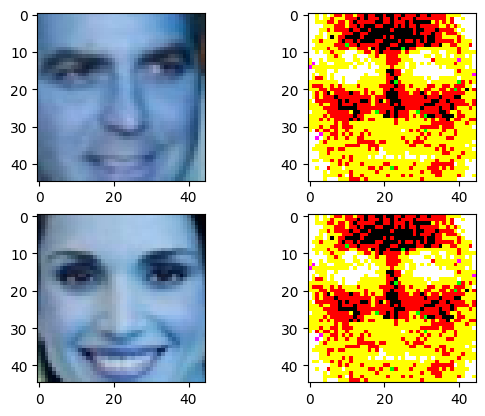

313/313 [==============================] - 2s 5ms/step - loss: -2415.9596 - kl_loss: -6.5679e-08 - log_likelihood: 2415.9596
Epoch 22/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.0055 - kl_loss: 2.2020e-08 - log_likelihood: 2416.0055
Epoch 23/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.2998 - kl_loss: 4.5653e-08 - log_likelihood: 2416.2998
Epoch 24/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.0568 - kl_loss: 1.2984e-07 - log_likelihood: 2416.0568
Epoch 25/30
313/313 [==============================] - 1s 4ms/step - loss: -2416.0686 - kl_loss: 1.6372e-07 - log_likelihood: 2416.0686
Epoch 26/30
313/313 [==============================] - 2s 6ms/step - loss: -2416.0817 - kl_loss: 1.5812e-07 - log_likelihood: 2416.0817
Epoch 27/30
313/313 [==============================] - 2s 5ms/step - loss: -2416.2003 - kl_loss: 1.8963e-07 - log_likelihood: 2416.2003
Epoch 28/30
313/313 [==============================] - 1s 4

In [27]:
print(X_train.shape)
history = vae.fit(X_train, epochs=30, callbacks=[callback])

Plot the learning curves

And finally sample from VAE.

1/1 [==============================] - 0s 20ms/step


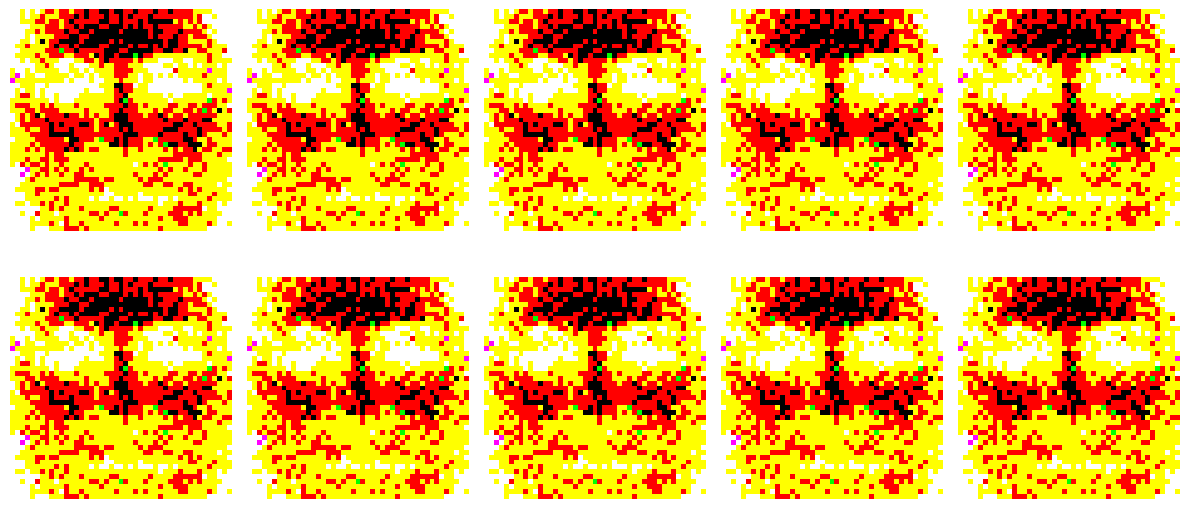

In [28]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))


num_samples = 10
z = np.random.normal(size=(num_samples, dimZ))

samples = vae.decoder.predict(z)
samples = samples.reshape((-1, 45, 45, 3))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i])
    ax.axis('off')

plt.tight_layout()
plt.show()




In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

# Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="https://github.com/SnkhchyanV/NeuralNetworks/blob/main/linear.png?raw=1" alt="linear">

In [23]:
# your code here
# if you see this message, bonus will be updated later :)

Vanila autoencoders are not suitable for this task